# Load and Analyze Sample Files with PySpark

This notebook loads sample eTRP data files using PySpark and performs exploratory data analysis including:
- Frequency analysis for categorical variables
- Histograms for numerical variables

In [1]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType
from pyspark.sql.functions import col, count, when, isnan, isnull
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Load Sample Files Analysis") \
    .master("local[*]") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/08 00:07:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 3.5.6


In [3]:
# Define the PySpark schema based on draft_schema_raw.yaml
draft_schema_raw = StructType([
    StructField("payment_code", StringType(), False),
    StructField("operation_code", StringType(), False),
    StructField("party_type", StringType(), False),
    StructField("name", StringType(), False),
    StructField("company_reg_no", StringType(), True),
    StructField("business_reg_no", StringType(), True),
    StructField("passport", StringType(), True),
    StructField("account", StringType(), False),
    StructField("account_status", IntegerType(), False),
    StructField("relationship_start_date", StringType(), False),
    StructField("relationship_type", IntegerType(), False),
    StructField("agreement_date", StringType(), False),
    StructField("statement_date", StringType(), True),
    StructField("capacity", IntegerType(), True),
    StructField("facility", IntegerType(), True),
    StructField("credit_limit", DecimalType(18, 2), True),
    StructField("instalment_amount", DecimalType(18, 2), True),
    StructField("amount_in_arrears", DecimalType(18, 2), True),
    StructField("month_in_arrears", IntegerType(), True),
    StructField("tenure", IntegerType(), True),
    StructField("total_balance_outstanding", DecimalType(18, 2), True),
    StructField("late_payment_interest", IntegerType(), True),
    StructField("principal_repayment_term", IntegerType(), True),
    StructField("collateral_type", IntegerType(), True),
    StructField("legal_status", IntegerType(), True),
    StructField("date_status_update", StringType(), True),
    StructField("deletion_reason_code", IntegerType(), True),
    StructField("total_amount_paid", DecimalType(18, 2), True),
    StructField("debt_type", StringType(), True),
    StructField("email", StringType(), True),
    StructField("mobile_no", StringType(), True),
    StructField("date_of_notice", StringType(), True),
    StructField("sponsor_constitution", StringType(), True),
    StructField("sponsor_old_ic_company_reg_no", StringType(), True),
    StructField("sponsor_new_ic_business_reg_no", StringType(), True),
    StructField("sponsor_passport_no", StringType(), True),
    StructField("sponsor_name", StringType(), True),
    StructField("sponsor_status", IntegerType(), True),
    StructField("sponsor_remarks", StringType(), True),
    StructField("old_account_no", StringType(), True)
])

In [4]:
# Load sample file
sample_file = "../samples/jcl_202412_20250104_0925.txt"

df = spark.read \
    .option("header", "true") \
    .option("delimiter", "|") \
    .option("mode", "PERMISSIVE") \
    .schema(draft_schema_raw) \
    .csv(sample_file)

# Cache for better performance
df.cache()

print(f"Total rows loaded: {df.count()}")
print(f"Total columns: {len(df.columns)}")

25/07/08 00:08:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Total rows loaded: 1000
Total columns: 40


## Identify Categorical and Numerical Variables

In [ ]:
# Identify categorical and numerical columns
categorical_cols = []
numerical_cols = []

for field in df.schema.fields:
    if isinstance(field.dataType, (StringType, IntegerType)):
        # Check if it's a categorical variable by counting distinct values
        distinct_count = df.select(field.name).distinct().count()
        if distinct_count <= 30 and isinstance(field.dataType, (StringType, IntegerType)):
            categorical_cols.append(field.name)
        elif isinstance(field.dataType, IntegerType) and distinct_count > 30:
            numerical_cols.append(field.name)
    elif isinstance(field.dataType, DecimalType):
        numerical_cols.append(field.name)

# Remove ID-like fields and dates from categorical
exclude_from_categorical = ['name', 'company_reg_no', 'business_reg_no', 'passport', 
                           'account', 'email', 'mobile_no', 'old_account_no',
                           'sponsor_old_ic_company_reg_no', 'sponsor_new_ic_business_reg_no',
                           'sponsor_passport_no', 'sponsor_name', 'sponsor_remarks',
                           'relationship_start_date', 'agreement_date', 'statement_date',
                           'date_status_update', 'date_of_notice']

categorical_cols = [col_name for col_name in categorical_cols if col_name not in exclude_from_categorical]

print(f"Categorical variables ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical variables ({len(numerical_cols)}): {numerical_cols}")

## Frequency Analysis for Categorical Variables

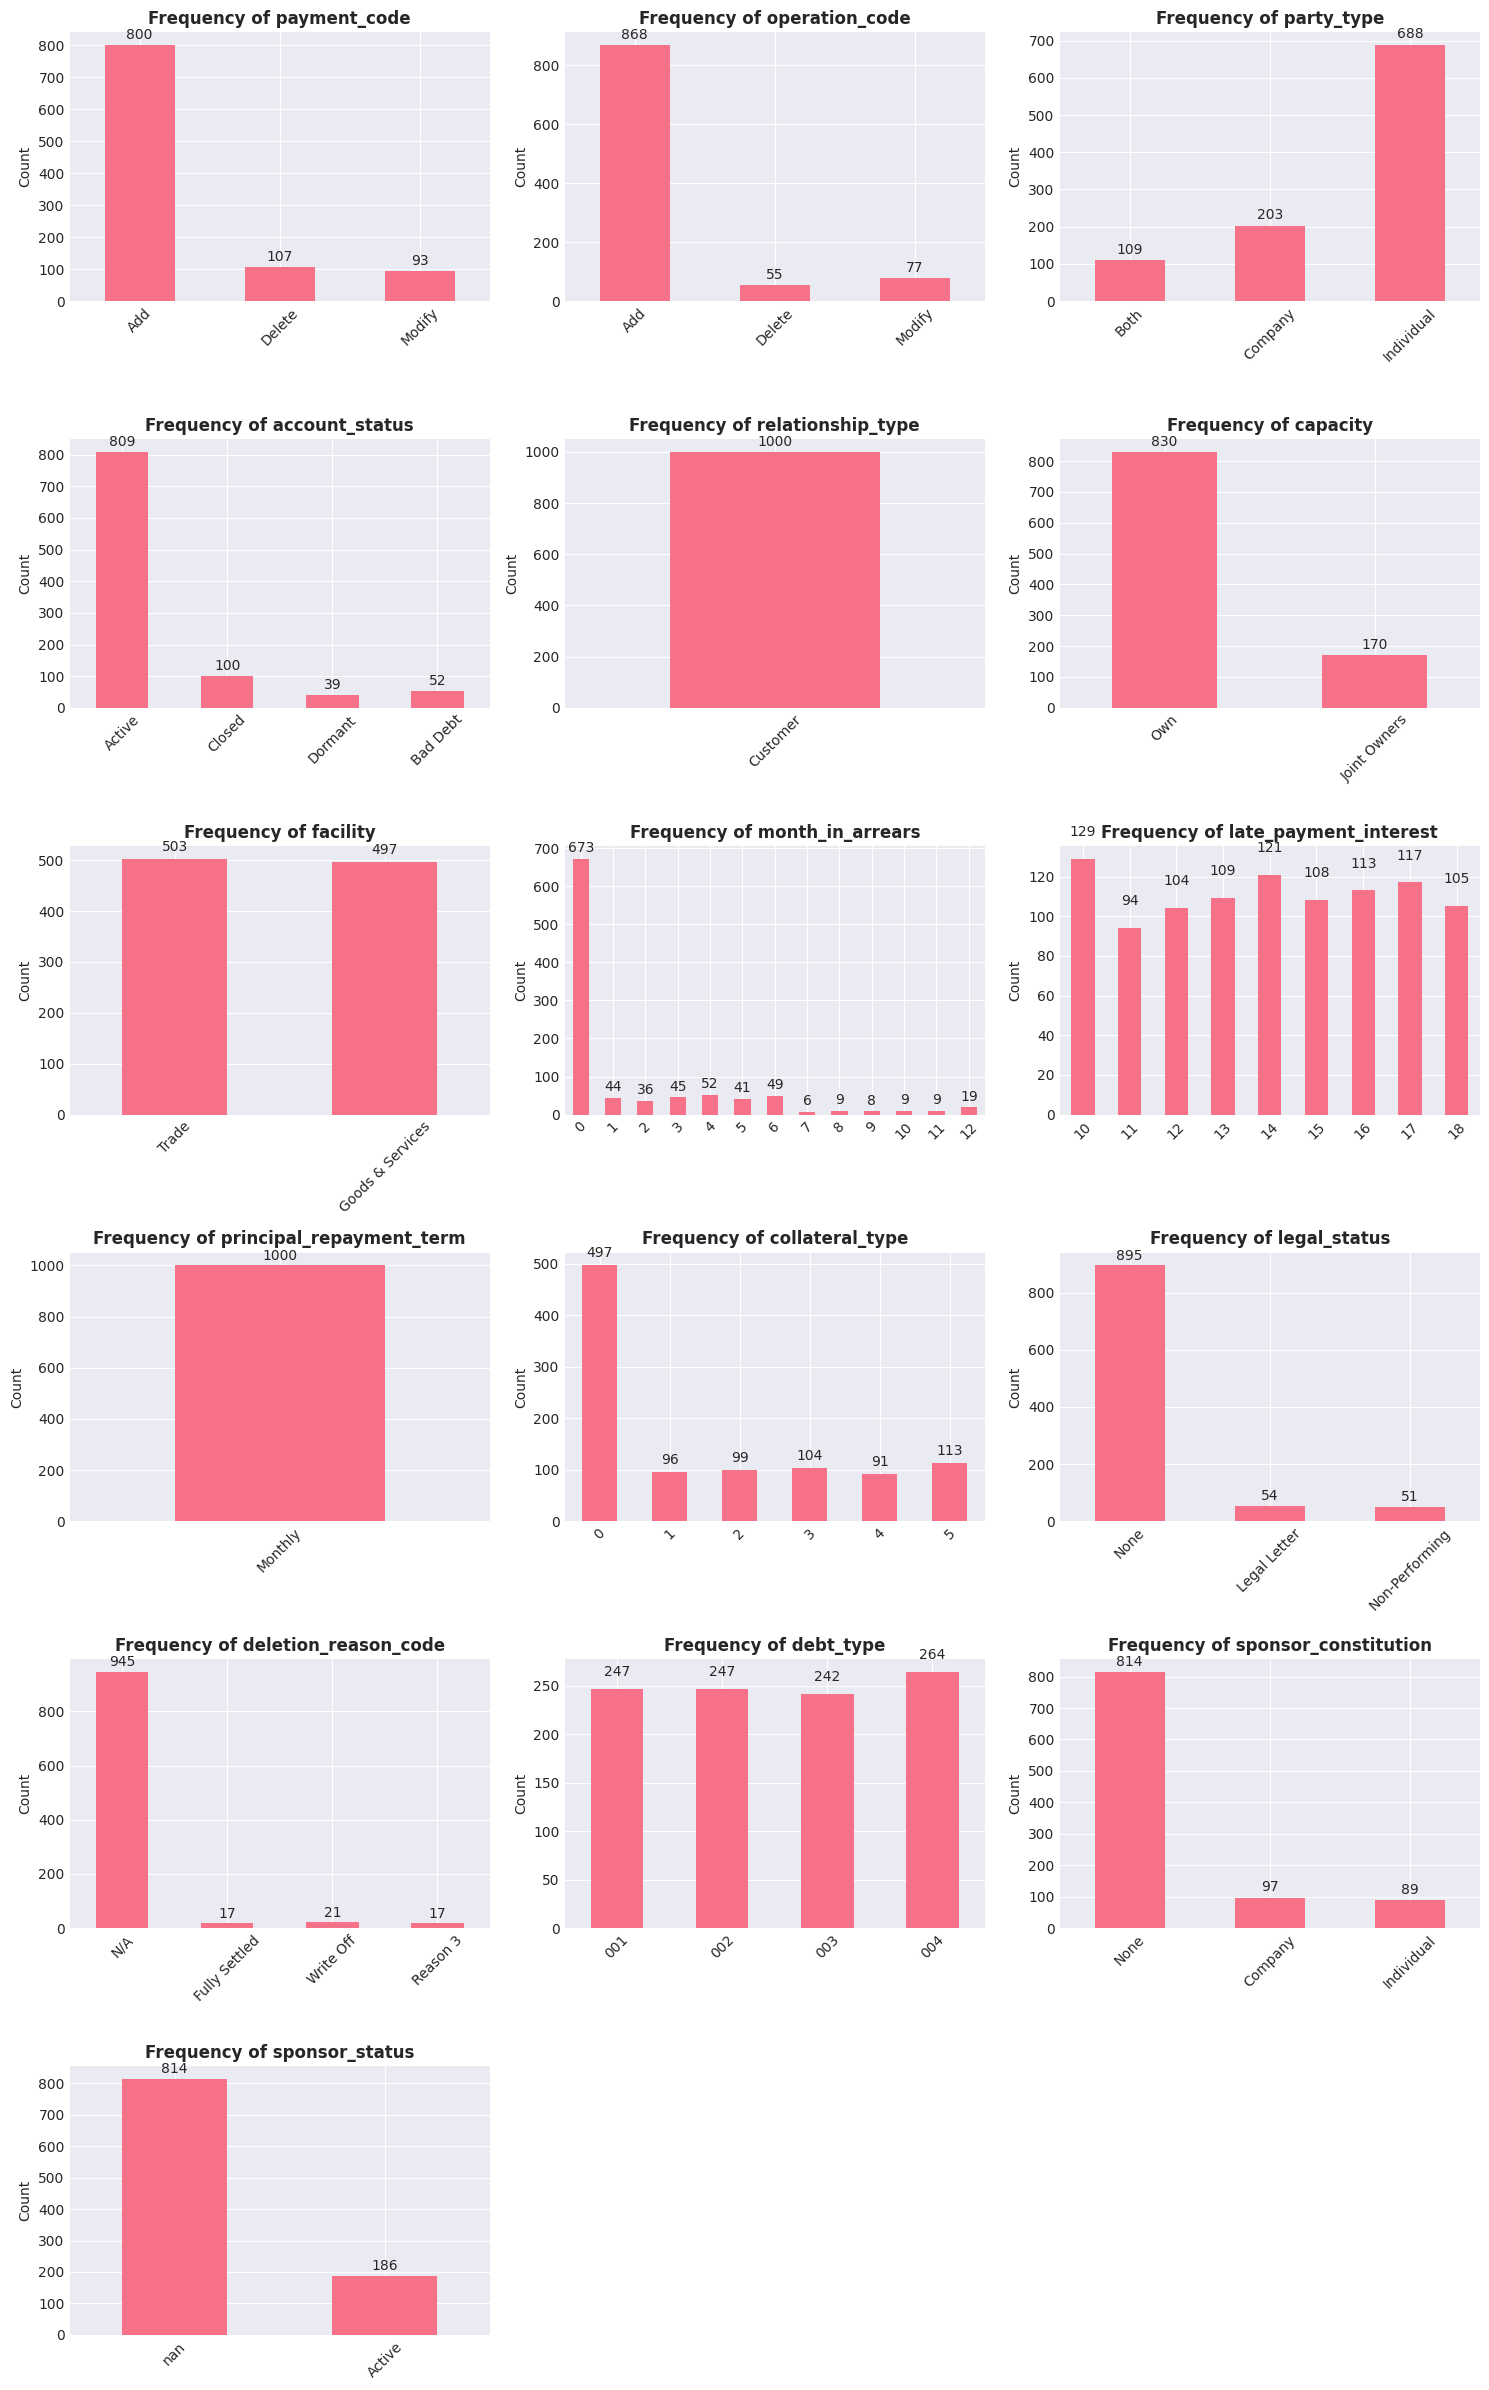

In [6]:
# Create frequency plots for categorical variables
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

# Define labels for better visualization
labels_map = {
    'payment_code': {'A': 'Add', 'M': 'Modify', 'D': 'Delete'},
    'operation_code': {'A': 'Add', 'M': 'Modify', 'D': 'Delete'},
    'party_type': {'I': 'Individual', 'C': 'Company', 'B': 'Both'},
    'account_status': {1: 'Active', 2: 'Closed', 3: 'Dormant', 4: 'Bad Debt'},
    'relationship_type': {1: 'Customer', 2: 'Co-borrower', 3: 'Type 3', 4: 'Type 4', 
                         5: 'Type 5', 6: 'Type 6', 7: 'Type 7', 8: 'Type 8'},
    'capacity': {1: 'Own', 2: 'Joint Owners'},
    'facility': {1: 'Trade', 2: 'Goods & Services', 3: 'Personal', 
                4: 'Equipment/Vehicle', 5: 'Property', 6: 'Other'},
    'principal_repayment_term': {1: 'Monthly', 2: 'Quarterly', 3: 'Semi-Annual', 
                                4: 'Annual', 5: 'On Demand'},
    'legal_status': {0: 'None', 1: 'Legal Letter', 2: 'Non-Performing'},
    'deletion_reason_code': {0: 'N/A', 1: 'Fully Settled', 2: 'Write Off', 
                            3: 'Reason 3', 4: 'Reason 4', 5: 'Reason 5', 
                            6: 'Reason 6', 7: 'Reason 7'},
    'sponsor_constitution': {'I': 'Individual', 'C': 'Company', 'B': 'Both'},
    'sponsor_status': {1: 'Active', 2: 'Inactive', 3: 'Other'}
}

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        # Get frequency data
        freq_df = df.groupBy(col).count().orderBy(col).toPandas()
        
        # Apply labels if available
        if col in labels_map:
            freq_df[col] = freq_df[col].map(lambda x: labels_map[col].get(x, str(x)))
        
        # Create bar plot
        ax = axes[idx]
        freq_df.plot(x=col, y='count', kind='bar', ax=ax, legend=False)
        ax.set_title(f'Frequency of {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(freq_df['count']):
            ax.text(i, v + 10, str(v), ha='center', va='bottom')

# Hide empty subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Summary Statistics for Numerical Variables

In [7]:
# Display summary statistics for numerical variables
numerical_df = df.select(numerical_cols).summary().toPandas()
numerical_df = numerical_df[numerical_df['summary'].isin(['count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max'])]
print("Summary Statistics for Numerical Variables:")
display(numerical_df)

Summary Statistics for Numerical Variables:


,summary,credit_limit,instalment_amount,amount_in_arrears,tenure,total_balance_outstanding,total_amount_paid
0,count,1000,1000,1000,1000,1000,1000
1,mean,26819.682250,9435.673230,14319.525130,105.271,12079.077770,437.887610
2,stddev,12931.437919669253,7124.886730152601,33404.45459725136,42.5555699707516,10918.364290352705,3867.9059859771846
3,min,5049.37,1013.49,0.00,30,0.00,0.00
4,25%,15614.74,4454.21,0.0,69,3344.18,0.0
5,50%,26793.84,7774.2,0.0,107,8938.61,0.0
6,75%,38028.49,12005.07,11974.92,141,18256.01,0.0
7,max,49973.01,47585.98,274677.00,180,47609.86,49069.59


## Histograms for Numerical Variables

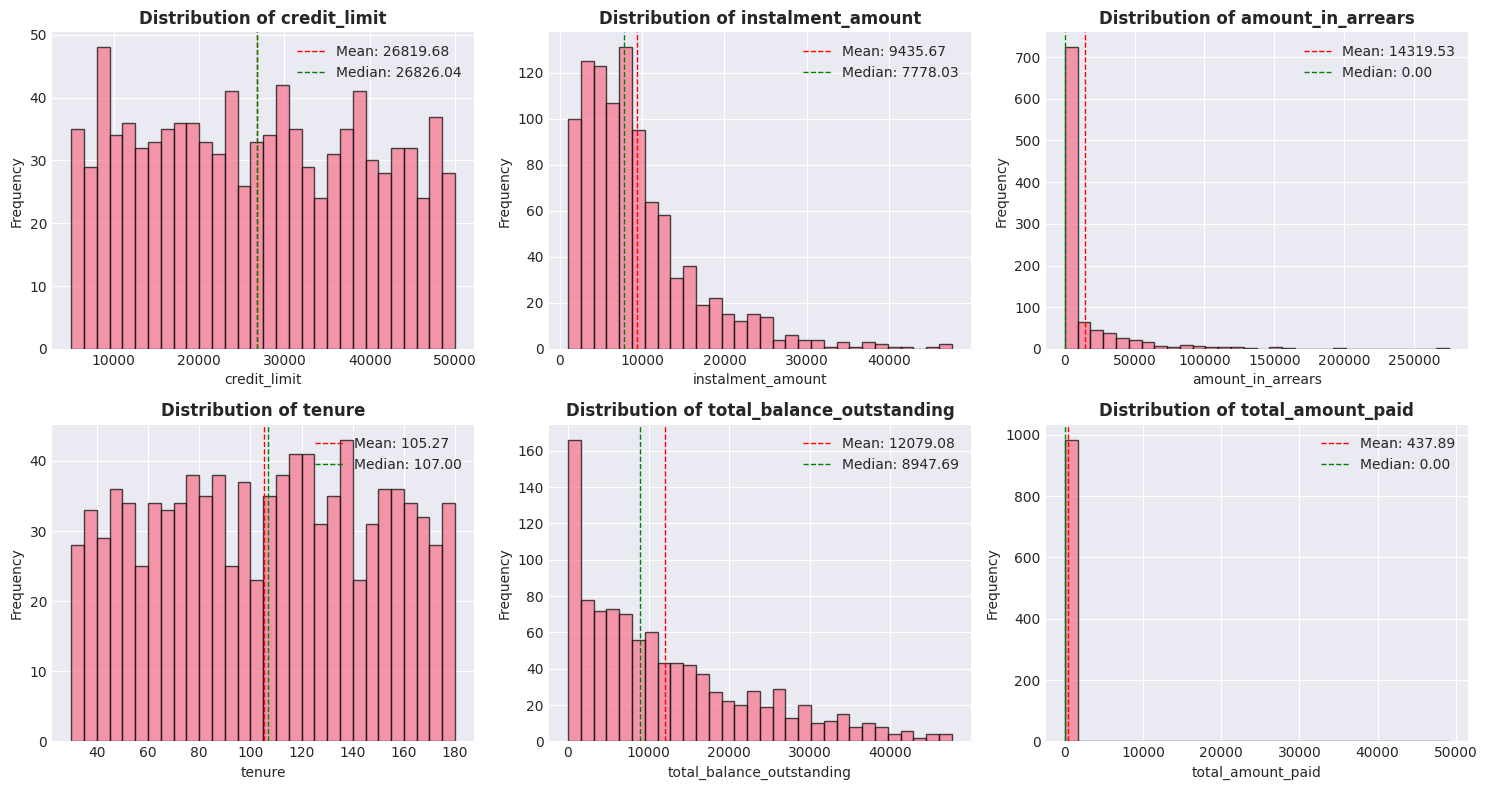

In [8]:
# Convert to Pandas for easier plotting
numerical_pandas_df = df.select(numerical_cols).toPandas()

# Convert Decimal columns to float for plotting
for col in numerical_cols:
    if numerical_pandas_df[col].dtype == 'object':
        numerical_pandas_df[col] = pd.to_numeric(numerical_pandas_df[col], errors='coerce')

# Create histograms for numerical variables
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        ax = axes[idx]
        
        # Remove null values for plotting
        data = numerical_pandas_df[col].dropna()
        
        # Create histogram
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        
        # Add statistics text
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
        ax.legend(loc='upper right')

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Box Plots for Numerical Variables

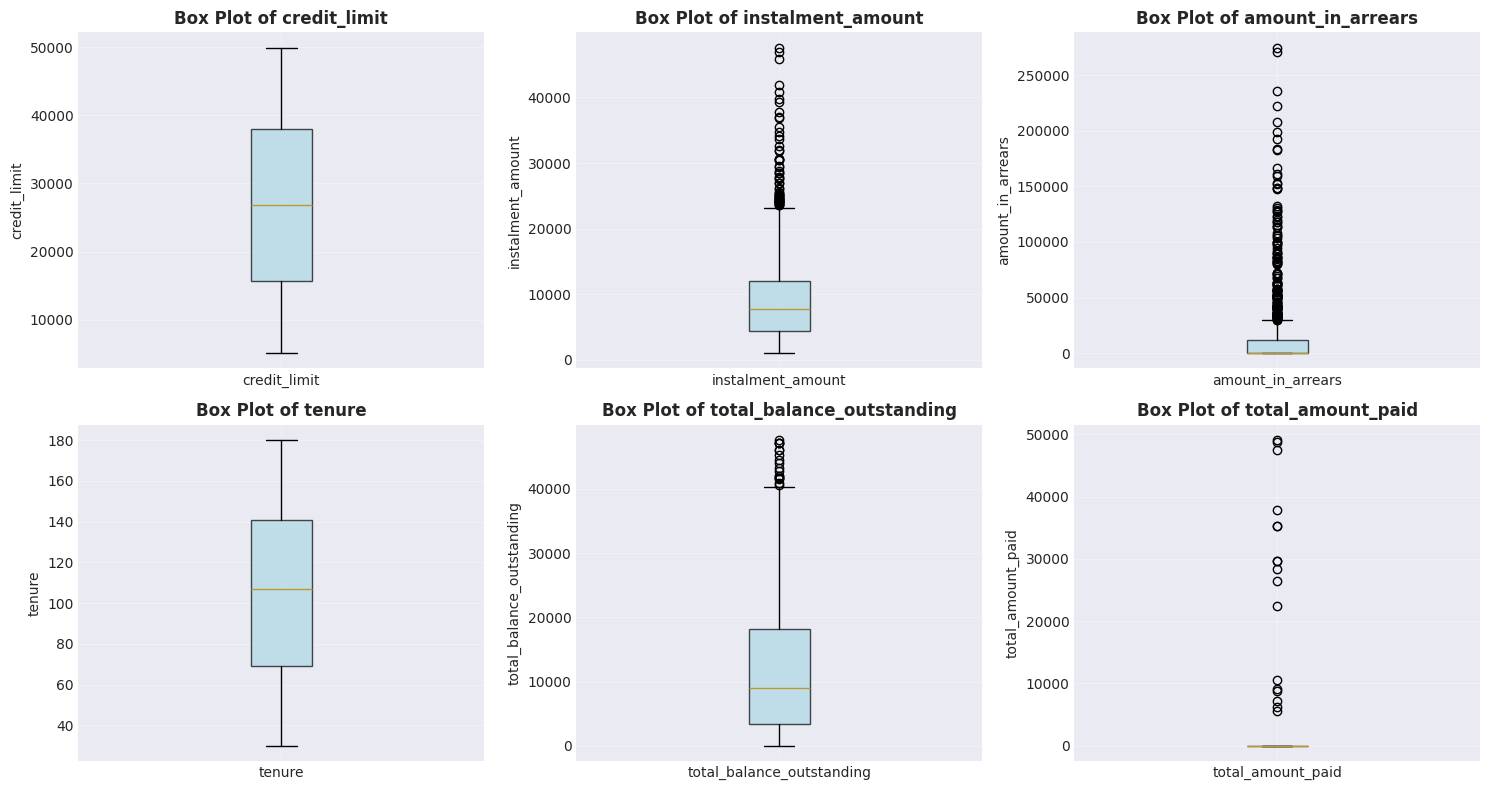

In [9]:
# Create box plots to show outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        ax = axes[idx]
        
        # Remove null values for plotting and convert to float
        data = numerical_pandas_df[col].dropna().astype(float)
        
        # Create box plot - wrap data in list for single box
        box_plot = ax.boxplot([data], vert=True, patch_artist=True)
        
        # Style the box plot
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][0].set_alpha(0.7)
        
        ax.set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
        ax.set_ylabel(col)
        ax.set_xticklabels([col])
        ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Correlation Analysis

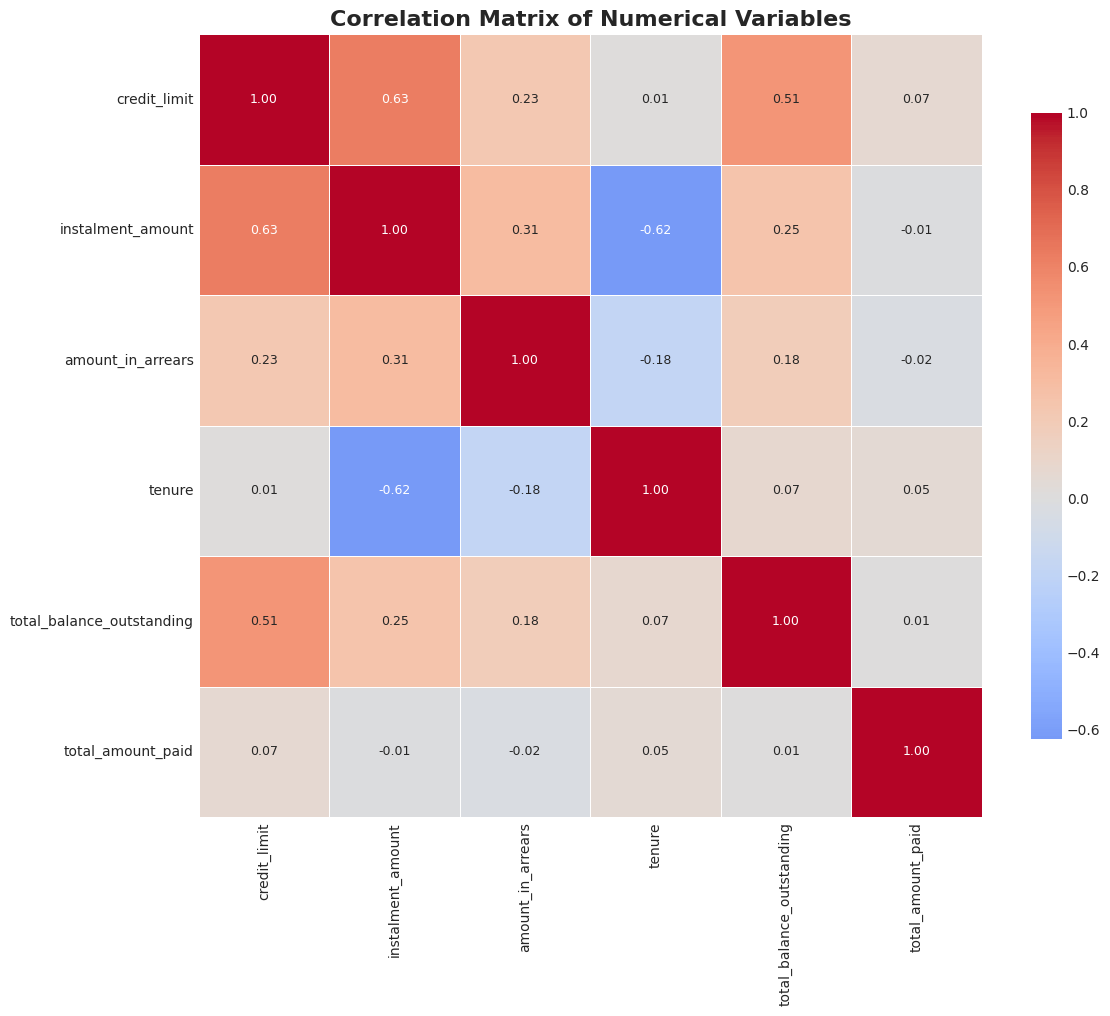

In [10]:
# Calculate correlation matrix for numerical variables
correlation_matrix = numerical_pandas_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            fmt='.2f', annot_kws={'size': 9})
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data Quality Check

In [ ]:
# Check for missing values
missing_data = []
for column_name in df.columns:
    # For numeric columns, check both null and NaN
    if column_name in numerical_cols:
        null_count = df.filter(col(column_name).isNull() | isnan(col(column_name))).count()
    else:
        # For non-numeric columns, only check for null
        null_count = df.filter(col(column_name).isNull()).count()
    
    total_count = df.count()
    missing_percent = (null_count / total_count) * 100
    if null_count > 0:
        missing_data.append({
            'Column': column_name,
            'Missing_Count': null_count,
            'Missing_Percentage': f"{missing_percent:.2f}%"
        })

missing_df = pd.DataFrame(missing_data)
if not missing_df.empty:
    missing_df = missing_df.sort_values('Missing_Count', ascending=False)
    print("Columns with Missing Values:")
    display(missing_df)
else:
    print("No missing values found in the dataset!")

In [ ]:
# Stop Spark session
spark.stop()
print("Spark session closed.")